In [ ]:
# !sudo apt install swig

In [ ]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

# Initializing

In [1]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from utils import PortfolioOptimizationEnv, custom_reward_function, sharpe_ratio_reward_function
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Data Import and Preprocessing

In [5]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "GOOG", "XOM"
]
START_DATE = '2011-01-01'
END_DATE = '2023-12-31'
print(len(TEST_SET))

##COVARIATE 1: PRICES

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()

10


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (32700, 8)


In [6]:
##COVARIATES 2,3: VIX, FEAR/GREED INDEX

combined_spy_vix_fear_greed = pd.read_csv('datasets/VIX_feargreed/spy_vix_fear_greed_2011_2023.csv')


portfolio_raw_df['date'] = pd.to_datetime(portfolio_raw_df['date'])
combined_spy_vix_fear_greed['Date'] = pd.to_datetime(combined_spy_vix_fear_greed['Date'])


df_portfolio_comb = pd.merge(portfolio_raw_df, combined_spy_vix_fear_greed, left_on='date', right_on='Date', how='left')


df_portfolio_comb = df_portfolio_comb.drop(columns=['Date'])
df_portfolio_comb['date'] = df_portfolio_comb['date'].dt.strftime('%Y-%m-%d')

In [7]:
##COVARIATE 4: STOCK HISTORICAL RATINGS

FMP_historical_ratings = pd.read_csv('datasets/historical_ratings/FMP_historical_ratings.csv')

df_portfolio_comb_2 = df_portfolio_comb.merge(
    FMP_historical_ratings[['date', 'symbol', 'ratingScore', 'ratingDetailsDCFScore', 'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore']],
    left_on=['date', 'tic'],
    right_on=['date', 'symbol'],
    how='left' )

df_portfolio_comb_2.drop(columns=['symbol'], inplace=True)

In [8]:
##COVARIATE 5: Macro Indicators

expenses = pd.read_csv('datasets/macro_indicators/expenses.csv')
gdp = pd.read_csv('datasets/macro_indicators/gdp.csv')
goods_services = pd.read_csv('datasets/macro_indicators/goods_and_services.csv')
pound_dollar = pd.read_csv('datasets/macro_indicators/pound-dollar-exchange-rate-historical-chart.csv')
unemployment = pd.read_csv('datasets/macro_indicators/unemployment.csv')
index_consumer_services = pd.read_csv('datasets/macro_indicators/index_consumer_services.csv')

df_portfolio_comb_2['date'] = pd.to_datetime(df_portfolio_comb_2['date'])
expenses['date'] = pd.to_datetime(unemployment['date'])
gdp['date'] = pd.to_datetime(gdp['DATE'])
goods_services['date'] = pd.to_datetime(goods_services['date'])
pound_dollar['date'] = pd.to_datetime(pound_dollar['date'])
unemployment['date'] = pd.to_datetime(unemployment['date'])
index_consumer_services['date'] = pd.to_datetime(index_consumer_services['date'])

df_portfolio_comb_3 = pd.merge(df_portfolio_comb_2, expenses, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, gdp, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, goods_services, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, pound_dollar, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, unemployment, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, index_consumer_services, on='date', how='left')

# Sort the dataframe by date (and optionally 'tic' if needed)
df_portfolio_comb_3 = df_portfolio_comb_3.sort_values(by=['date', 'tic'])

# Forward fill missing data
df_portfolio_comb_3['expenses'] = df_portfolio_comb_3['expenses'].ffill()
df_portfolio_comb_3['GDP'] = df_portfolio_comb_3['GDP'].ffill()
df_portfolio_comb_3['exports'] = df_portfolio_comb_3['exports'].ffill()
df_portfolio_comb_3['imports'] = df_portfolio_comb_3['imports'].ffill()
df_portfolio_comb_3['pound_dollar_exchange_rate'] = df_portfolio_comb_3['pound_dollar_exchange_rate'].ffill()
df_portfolio_comb_3['unemployment'] = df_portfolio_comb_3['unemployment'].ffill()
df_portfolio_comb_3['ics'] = df_portfolio_comb_3['ics'].ffill()
df_portfolio_comb_3.drop(columns=['DATE'], inplace=True)

In [9]:
##COVARIATE 6: Fundamental Indicators

DBITDA_ratio = pd.read_csv('datasets/fundemental indicators/DBITDA_ratio.csv')
PB_ratio = pd.read_csv('datasets/fundemental indicators/PB_ratio.csv')
PE_ratio = pd.read_csv('datasets/fundemental indicators/PE_ratio.csv')
PS_ratio = pd.read_csv('datasets/fundemental indicators/PS_ratio.csv')
quarterly_data = pd.read_csv('datasets/fundemental indicators/quaterlydata.csv')
ROE = pd.read_csv('datasets/fundemental indicators/ROE.csv')

df_portfolio_comb_3['date'] = pd.to_datetime(df_portfolio_comb_3['date'])
DBITDA_ratio['date'] = pd.to_datetime(DBITDA_ratio['date'])
PB_ratio['date'] = pd.to_datetime(PB_ratio['date'])
PE_ratio['date'] = pd.to_datetime(PE_ratio['date'])
PS_ratio['date'] = pd.to_datetime(PS_ratio['date'])
quarterly_data['date'] = pd.to_datetime(quarterly_data['date'])
ROE['date'] = pd.to_datetime(ROE['date'])

df_portfolio_comb_4 = df_portfolio_comb_3

df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, DBITDA_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PB_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PE_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PS_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, quarterly_data, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, ROE, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])

# Sort the dataframe by date (and optionally 'tic' if needed)
df_portfolio_comb_4 = df_portfolio_comb_4.sort_values(by=['tic', 'date'])

# Forward fill missing data
df_portfolio_comb_4['TTM Revenue(Billion)'] = df_portfolio_comb_4['TTM Revenue(Billion)'].ffill()
df_portfolio_comb_4['TTM EBITDA(Billion)'] = df_portfolio_comb_4['TTM EBITDA(Billion)'].ffill()
df_portfolio_comb_4['EBITDA Margin'] = df_portfolio_comb_4['EBITDA Margin'].ffill()
df_portfolio_comb_4['Price to Book Ratio'] = df_portfolio_comb_4['Price to Book Ratio'].ffill()
df_portfolio_comb_4['PE Ratio'] = df_portfolio_comb_4['PE Ratio'].ffill()
df_portfolio_comb_4['Price to Sales Ratio'] = df_portfolio_comb_4['Price to Sales Ratio'].ffill()
df_portfolio_comb_4['Assets'] = df_portfolio_comb_4['Assets'].ffill()
df_portfolio_comb_4['NetIncomeLoss'] = df_portfolio_comb_4['NetIncomeLoss'].ffill()
df_portfolio_comb_4['Return on Equity(%)'] = df_portfolio_comb_4['Return on Equity(%)'].ffill()

C:\Users\limyi\AppData\Local\Temp\ipykernel_32884\1570567354.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  DBITDA_ratio['date'] = pd.to_datetime(DBITDA_ratio['date'])
C:\Users\limyi\AppData\Local\Temp\ipykernel_32884\1570567354.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  PB_ratio['date'] = pd.to_datetime(PB_ratio['date'])
C:\Users\limyi\AppData\Local\Temp\ipykernel_32884\1570567354.py:13: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  PE_ratio['date'] = pd.to_datetime(PE_ratio['date'])
C:\Users\limyi\AppData\Local\Temp\ipykernel_32884\1570567354.py:14: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the defa

In [10]:
df_portfolio_final = df_portfolio_comb_4

In [11]:
# Check the data types of all columns in the DataFrame
print(df_portfolio_final.dtypes)

date                              datetime64[ns]
open                                     float64
high                                     float64
low                                      float64
close                                    float64
volume                                     int64
tic                                       object
day                                        int32
Open_VIX                                 float64
High_VIX                                 float64
Low_VIX                                  float64
Close_VIX                                float64
Adj Close_VIX                            float64
Open_SPY                                 float64
High_SPY                                 float64
Low_SPY                                  float64
Close_SPY                                float64
Adj Close_SPY                            float64
Volume_SPY                                 int64
Fear Greed                               float64
ratingScore         

In [12]:
#Convert Str to Float64
df_portfolio_final['net_export_goods_and_services'] = df_portfolio_final['net_export_goods_and_services'].str.replace(',', '').astype('float64')
df_portfolio_final['expenses'] = df_portfolio_final['expenses'].str.replace(',', '').astype('float64')
df_portfolio_final['exports'] = df_portfolio_final['exports'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_goods'] = df_portfolio_final['exports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_services'] = df_portfolio_final['exports_services'].str.replace(',', '').astype('float64')
df_portfolio_final['imports'] = df_portfolio_final['imports'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_goods'] = df_portfolio_final['imports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_services'] = df_portfolio_final['imports_services'].str.replace(',', '').astype('float64')

#Convert rest to Float64
df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])] = df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])].astype('float64')

#Convert date back
df_portfolio_final['date'] = df_portfolio_final['date'].dt.strftime('%Y-%m-%d')

In [13]:
# Filling NaN values with 0
df_portfolio_final.fillna(0, inplace=True)

In [14]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(df_portfolio_final)
portfolio_norm_df

,date,open,high,low,close,volume,tic,day,Open_VIX,High_VIX,...,Price to Book Ratio,Net EPS,PE Ratio,TTM Sales per Share,Price to Sales Ratio,Assets,NetIncomeLoss,TTM Net Income (Billions),Shareholder's Equity (Billion),Return on Equity(%)
0,2011-01-03,0.058731,0.059087,0.058891,0.050363,0.236650,AAPL,0.00,0.216955,0.210015,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
10,2011-01-04,0.059958,0.059488,0.059491,0.050626,0.164317,AAPL,0.25,0.209699,0.213408,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
20,2011-01-05,0.059437,0.059817,0.059735,0.051040,0.135843,AAPL,0.50,0.215383,0.210015,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
30,2011-01-06,0.060369,0.059980,0.060352,0.050999,0.159718,AAPL,0.75,0.203168,0.205452,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
40,2011-01-07,0.060237,0.060177,0.060170,0.051364,0.165833,AAPL,1.00,0.209336,0.211419,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32659,2023-12-22,0.852725,0.852858,0.861494,0.855590,0.152474,XOM,1.00,0.165921,0.163332,...,0.269648,0.0,0.223856,0.0,0.253363,0.963788,0.561798,0.0,0.0,0.807644
32669,2023-12-26,0.856309,0.853604,0.864032,0.857521,0.198649,XOM,0.25,0.166526,0.161460,...,0.269648,0.0,0.223856,0.0,0.253363,0.963788,0.561798,0.0,0.0,0.807644
32679,2023-12-27,0.850475,0.849627,0.857433,0.853491,0.171790,XOM,0.50,0.157456,0.152568,...,0.269648,0.0,0.223856,0.0,0.253363,0.963788,0.561798,0.0,0.0,0.807644
32689,2023-12-28,0.845057,0.841839,0.847195,0.841150,0.192681,XOM,0.75,0.150441,0.148005,...,0.269648,0.0,0.223856,0.0,0.253363,0.963788,0.561798,0.0,0.0,0.807644


In [15]:
df_portfolio = portfolio_norm_df[["date", 
                                  "tic", 
                                  "close",
                                  "high", 
                                  "low",
                                  'High_VIX',
                                  'Low_VIX',
                                  'Close_VIX',
                                  'High_SPY',
                                  'Low_SPY',
                                  'Close_SPY',
                                  'Volume_SPY',
                                  'Fear Greed', 
                                  'ratingScore',
                                  'ratingDetailsDCFScore',
                                  'ratingDetailsROEScore',
                                  'ratingDetailsROAScore',
                                  'ratingDetailsPEScore',
                                  'ratingDetailsPBScore',
                                  'expenses',
                                  'GDP', 
                                  'exports', 
                                  'imports',
                                  'pound_dollar_exchange_rate', 
                                  'unemployment',
                                  'ics',
                                  'TTM Revenue(Billion)',
                                  'TTM EBITDA(Billion)',
                                  'EBITDA Margin',
                                  'Price to Book Ratio',
                                  'PE Ratio',
                                  'Price to Sales Ratio',
                                  'Assets',
                                  'NetIncomeLoss',
                                  'Return on Equity(%)']]

In [16]:
df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_2023 = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

In [17]:
df_portfolio_2021.head()

,date,tic,close,high,low,High_VIX,Low_VIX,Close_VIX,High_SPY,Low_SPY,...,ics,TTM Revenue(Billion),TTM EBITDA(Billion),EBITDA Margin,Price to Book Ratio,PE Ratio,Price to Sales Ratio,Assets,NetIncomeLoss,Return on Equity(%)
25170,2021-01-04,AAPL,0.641887,0.669322,0.643452,0.341523,0.320591,0.326158,0.782220,0.766010,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357
25180,2021-01-05,AAPL,0.649823,0.659954,0.651929,0.334620,0.352423,0.306446,0.776074,0.772792,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357
25190,2021-01-06,AAPL,0.627949,0.656497,0.641523,0.313209,0.314623,0.303181,0.785408,0.775039,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357
25200,2021-01-07,AAPL,0.649376,0.659403,0.649036,0.279747,0.316186,0.270528,0.791491,0.789296,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357
25210,2021-01-08,AAPL,0.654981,0.664412,0.661066,0.273078,0.304391,0.260733,0.794804,0.791794,...,0.795858,0.745923,0.651918,0.804614,0.659604,1.0,0.956359,0.0,0.0,-0.171357


# Feature Selection and DRL Model Parameters

In [18]:
FEATURE_NAMES = ['close',
                 'high',
                 'low',
                 'High_VIX',
                 'Low_VIX',
                 'Close_VIX',
                 'High_SPY',
                 'Low_SPY',
                 'Close_SPY',
                 'Volume_SPY',
                 'Fear Greed', 
                 'ratingScore',
                 'ratingDetailsDCFScore',
                 'ratingDetailsROEScore',
                 'ratingDetailsROAScore',
                 'ratingDetailsPEScore',
                 'ratingDetailsPBScore',
                 'expenses',
                 'GDP', 
                 'exports', 
                 'imports',
                 'pound_dollar_exchange_rate',
                 'unemployment',
                 'ics',
                 'TTM Revenue(Billion)',
                 'TTM EBITDA(Billion)',
                 'EBITDA Margin',
                 'Price to Book Ratio',
                 'PE Ratio',
                 'Price to Sales Ratio',
                 'Assets',
                 'NetIncomeLoss',
                 'Return on Equity(%)']

TIME_WINDOW = 50
COMISSION_FEE = 0.0025
K_SIZE = 4
CONV_MID = 5
CONV_FINAL= 20

environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_function=custom_reward_function,
        reward_scaling=1.0
    )

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "initial_features": len(FEATURE_NAMES),
    "k_size": K_SIZE,
    "time_window": TIME_WINDOW,
    "conv_mid_features":CONV_MID,
    "conv_final_features":CONV_FINAL}

EIIE_model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

# DRL Model Training (Jan 2011- Dec 2020)

In [37]:
DRLAgent.train_model(EIIE_model, episodes=5)
torch.save(EIIE_model.train_policy.state_dict(), "policy_EIIE(test).pt")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 1841085.375
Final accumulative portfolio value: 18.41085375
Maximum DrawDown: -0.3102049324961774
Sharpe ratio: 1.2845557173341549


 20%|████████████████▌                                                                  | 1/5 [01:50<07:20, 110.08s/it]

Initial portfolio value:100000
Final portfolio value: 2712417.0
Final accumulative portfolio value: 27.12417
Maximum DrawDown: -0.31425963270922963
Sharpe ratio: 1.4278241748089906


 40%|█████████████████████████████████▏                                                 | 2/5 [03:39<05:28, 109.50s/it]

Initial portfolio value:100000
Final portfolio value: 2707119.5
Final accumulative portfolio value: 27.071195
Maximum DrawDown: -0.3142728346441741
Sharpe ratio: 1.3732223380481963


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [05:28<03:39, 109.61s/it]

Initial portfolio value:100000
Final portfolio value: 4257352.5
Final accumulative portfolio value: 42.573525
Maximum DrawDown: -0.31427277073985893
Sharpe ratio: 1.5521589427888631


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [07:17<01:49, 109.24s/it]

Initial portfolio value:100000
Final portfolio value: 3983403.5
Final accumulative portfolio value: 39.834035
Maximum DrawDown: -0.31427273281131085
Sharpe ratio: 1.520047169591113


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:06<00:00, 109.30s/it]


# DRL Model Evaluation (Jan 2021-Dec 2023)

In [20]:
import os
import shutil

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)

environment_2023 = PortfolioOptimizationEnv(
    df_portfolio_2023,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)

EIIE_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}
# EI3_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.

EIIE_policy = EIIE(time_window = TIME_WINDOW, device = device, initial_features = len(FEATURE_NAMES),
              k_size = K_SIZE, conv_mid_features = CONV_MID,conv_final_features = CONV_FINAL)

EIIE_policy.load_state_dict(torch.load("policy_EIIE(test).pt"))

environment.reset()
src_folder = "results/rl"
dst_folder = "results/train"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["train"]["value"] = environment._asset_memory["final"]
EIIE_results["train"]["actions"] = environment._actions_memory

src_folder = "results/rl"
dst_folder = "results/2021"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2021, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
EIIE_results["2021"]["actions"] = environment_2021._actions_memory

src_folder = "results/rl"
dst_folder = "results/2022"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2022, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
EIIE_results["2022"]["actions"] = environment_2022._actions_memory

src_folder = "results/rl"
dst_folder = "results/2023"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_2023, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]
EIIE_results["2023"]["actions"] = environment_2023._actions_memory


# EI3_policy = EI3(time_window=50, device=device)
# EI3_policy.load_state_dict(torch.load("policy_EI3.pt"))

# environment.reset()
# DRLAgent.DRL_validation(EI3_model, environment, policy=EI3_policy)
# EI3_results["train"]["value"] = environment._asset_memory["final"]
# environment_2021.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2021, policy=EI3_policy)
# EI3_results["2021"]["value"] = environment_2021._asset_memory["final"]
# environment_2022.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2022, policy=EI3_policy)
# EI3_results["2022"]["value"] = environment_2022._asset_memory["final"]
# environment_2023.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2023, policy=EI3_policy)
# EI3_results["2023"]["value"] = environment_2023._asset_memory["final"]

#uniform buy n hold
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
UBAH_results = {
    "train": {"value": [], "actions": []},
    "2021": {"value": [], "actions": []},
    "2022": {"value": [], "actions": []},
    "2023": {"value": [], "actions": []}
}

PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
    UBAH_results["train"]["actions"].append(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
    UBAH_results["2021"]["actions"].append(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
    UBAH_results["2022"]["actions"].append(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
    UBAH_results["2023"]["actions"].append(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]

C:\Users\limyi\AppData\Local\Temp\ipykernel_32884\2309431501.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_policy.load_state_dict(torch.load("policy_EIIE(test).p

Initial portfolio value:100000
Final portfolio value: 1752205.125
Final accumulative portfolio value: 17.52205125
Maximum DrawDown: -0.37851521069341365
Sharpe ratio: 1.2522630408088795
Initial portfolio value:100000
Final portfolio value: 155824.625
Final accumulative portfolio value: 1.55824625
Maximum DrawDown: -0.08796687012584126
Sharpe ratio: 2.5948078715992797
Initial portfolio value:100000
Final portfolio value: 77071.625
Final accumulative portfolio value: 0.77071625
Maximum DrawDown: -0.32120293972363556
Sharpe ratio: -0.7279767426941357
Initial portfolio value:100000
Final portfolio value: 127496.6171875
Final accumulative portfolio value: 1.274966171875
Maximum DrawDown: -0.14932359187290223
Sharpe ratio: 1.7068666241693478
Initial portfolio value:100000
Final portfolio value: 367372.09375
Final accumulative portfolio value: 3.6737209375
Maximum DrawDown: -0.3532225233264764
Sharpe ratio: 0.8227911960628405
Initial portfolio value:100000
Final portfolio value: 126713.820312

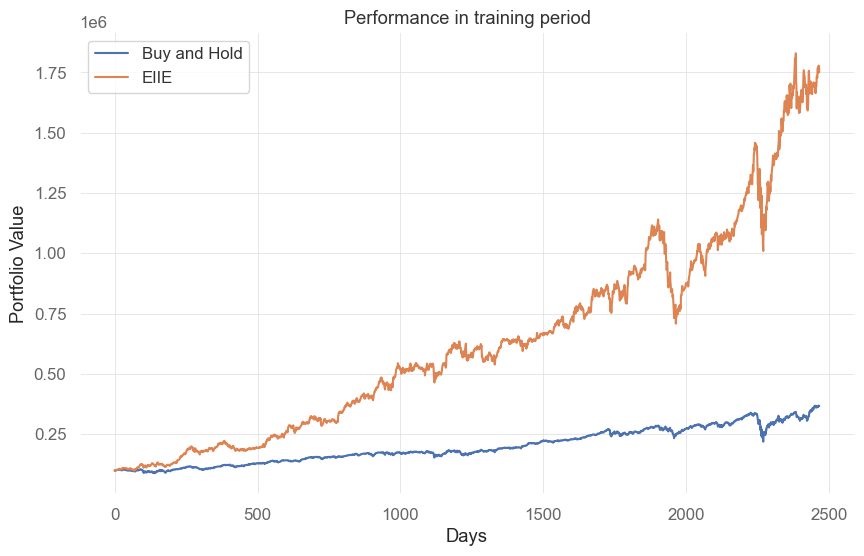

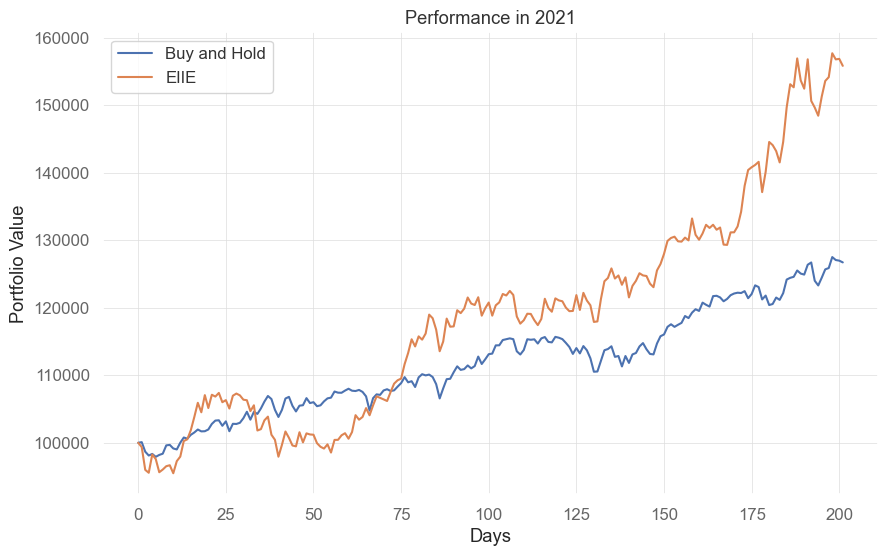

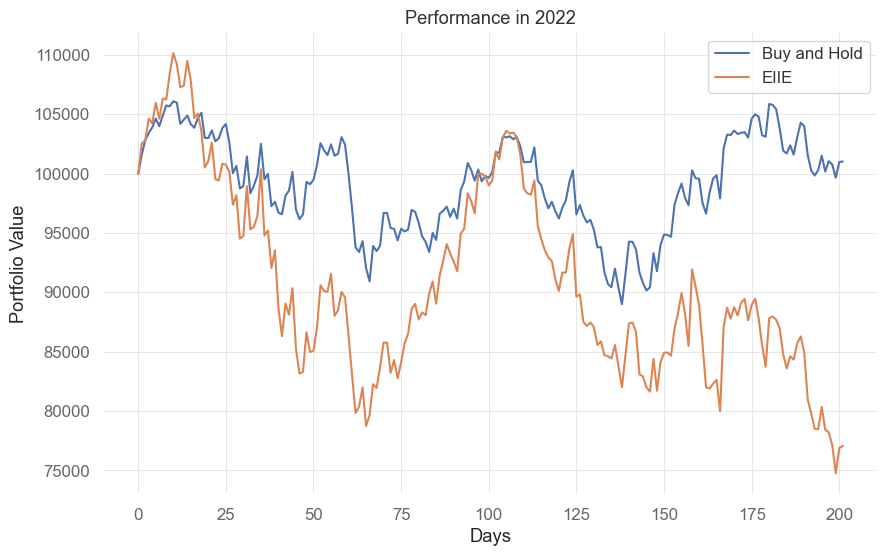

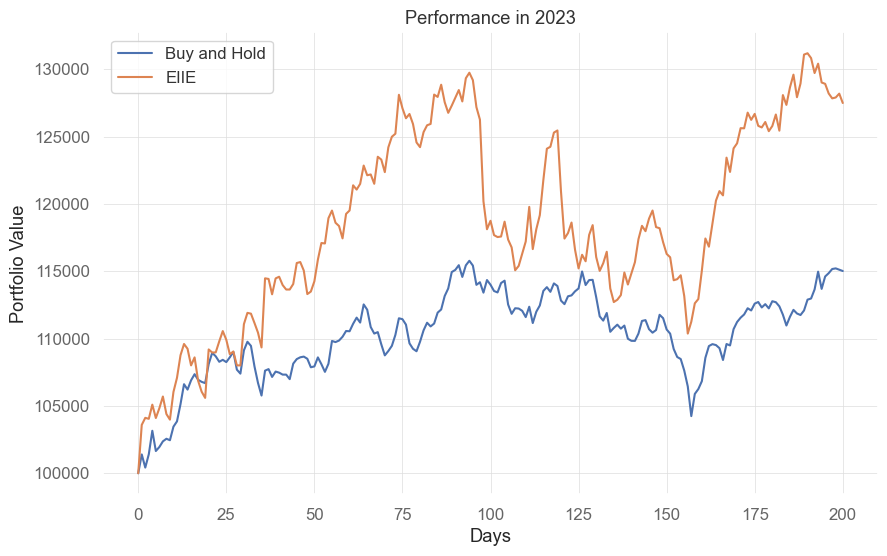

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")
#plt.plot(EI3_results["train"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")
#plt.plot(EI3_results["2021"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")
#plt.plot(EI3_results["2022"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

plt.plot(UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["value"], label="EIIE")
#plt.plot(EI3_results["2023"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()

# Portfolio Allocation by Trained DRL Model

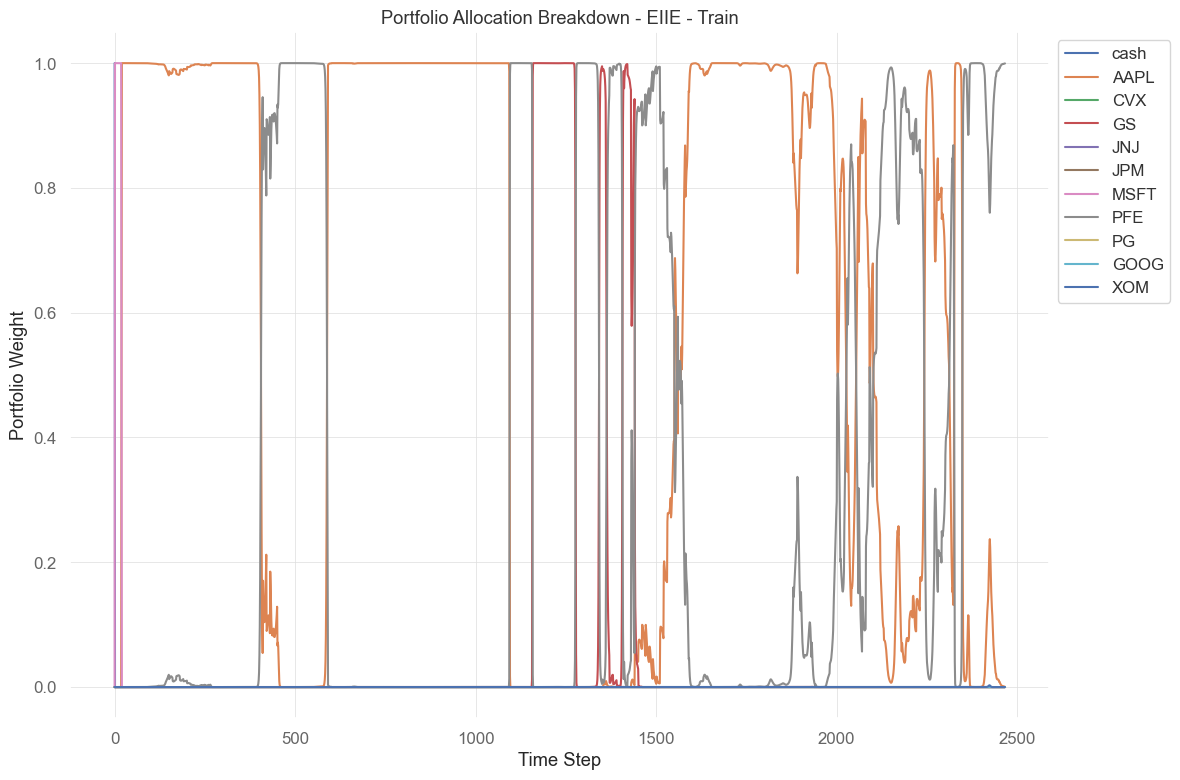

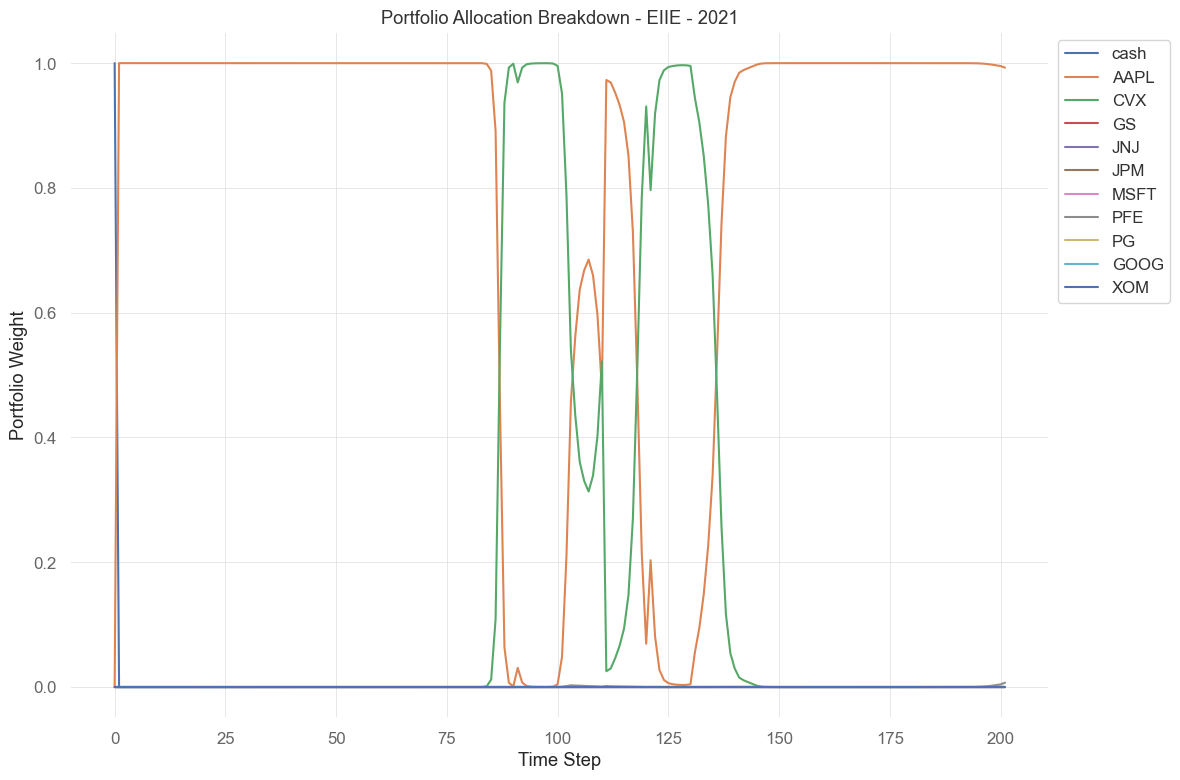

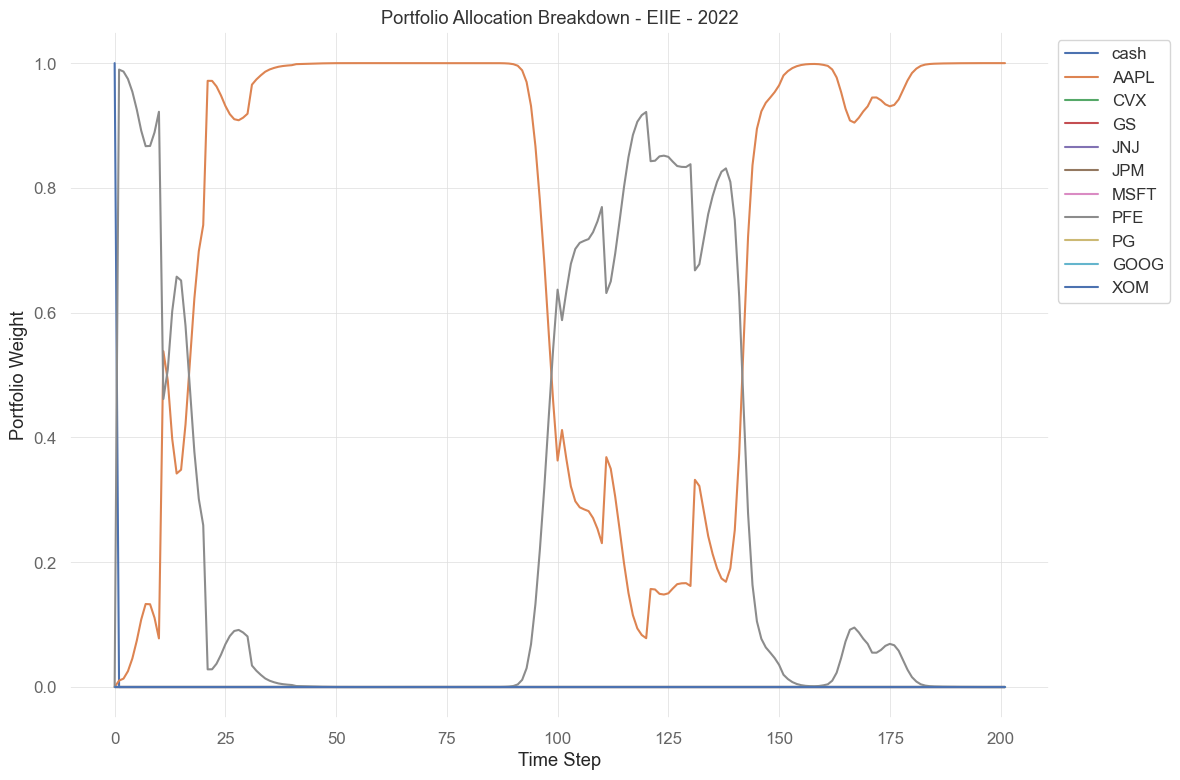

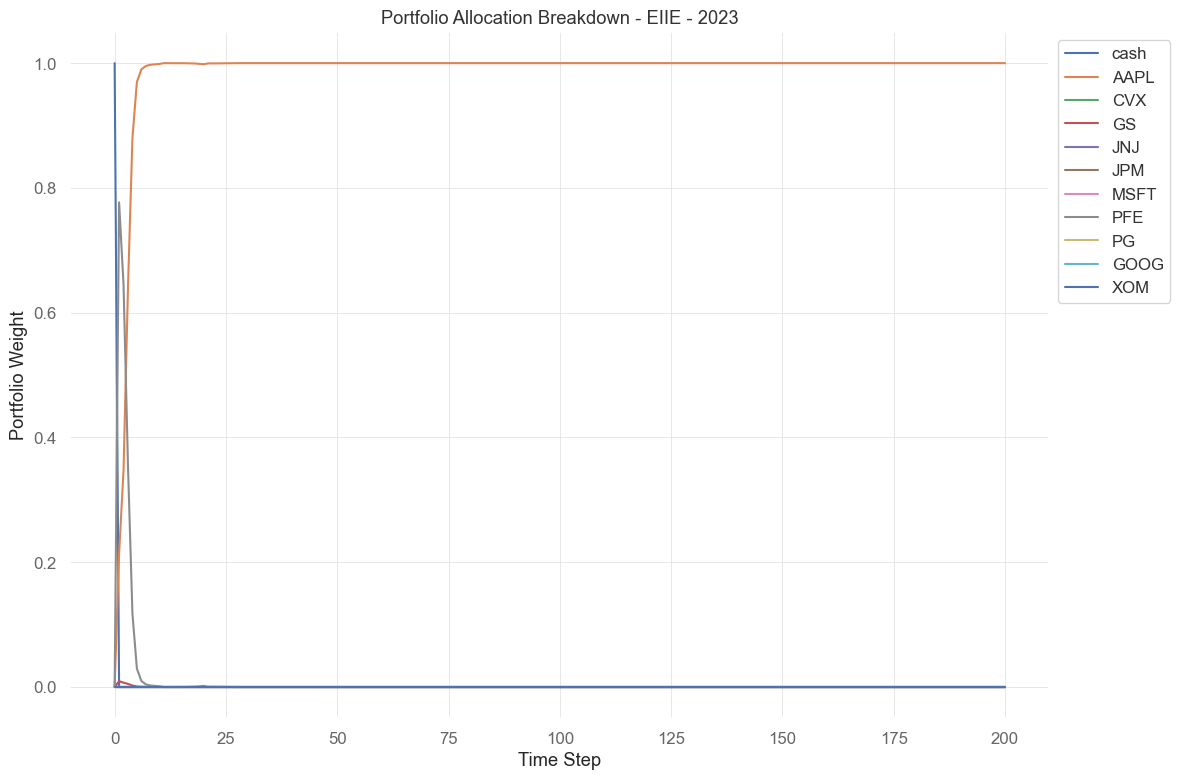

In [22]:
# Function to plot action memory
def plot_action_memory(actions, tickers, label):
    """Visualize portfolio allocation over time."""
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    actions_df.plot(kind="line", figsize=(12, 8), title=f"Portfolio Allocation Breakdown - {label}")
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Time Step")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot EIIE actions for the training period
plot_action_memory(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train")

# Plot EIIE actions for 2021
plot_action_memory(EIIE_results["2021"]["actions"], TEST_SET, "EIIE - 2021")

# Plot EIIE actions for 2022
plot_action_memory(EIIE_results["2022"]["actions"], TEST_SET, "EIIE - 2022")

# Plot EIIE actions for 2023
plot_action_memory(EIIE_results["2023"]["actions"], TEST_SET, "EIIE - 2023")

# Similarly, plot UBAH actions for each period
# plot_action_memory(UBAH_results["train"]["actions"], TEST_SET, "UBAH - Train")
# plot_action_memory(UBAH_results["2021"]["actions"], TEST_SET, "UBAH - 2021")
# plot_action_memory(UBAH_results["2022"]["actions"], TEST_SET, "UBAH - 2022")
# plot_action_memory(UBAH_results["2023"]["actions"], TEST_SET, "UBAH - 2023")